In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from PIL import Image

import re, string, unicodedata
import spacy
import contractions
import warnings
import inflect

import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
# from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder

import sys
sys.path.append('../../lib')

from helper_functions_2 import make_autopct, fast_mode , apply_labels 
from helper_functions_2 import MyTextTransformer, MyTextPlots

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
%matplotlib inline

#### load the data 

In [17]:
train = pd.read_csv("data/updated_train.csv")
test = pd.read_csv("data/updated_test.csv")

train.head()

,ID,text,target
0,train_0,The bitcoin halving is cancelled due to,1
1,train_1,MercyOfAllah In good times wrapped in its gran...,0
2,train_2,266 Days No Digital India No Murder of e learn...,1
3,train_3,India is likely to run out of the remaining RN...,1
4,train_4,In these tough times the best way to grow is t...,0


#### feature engineering for word count

In [18]:
def get_word_len(df, col="text"):
    df["wcount"] = df[col].apply(lambda x: len(x.split()))
    df["tlength"] = df[col].apply(lambda x: len(x))
    df["word_len"] = df["tlength"]/df["wcount"]
    return df

train = get_word_len(train, col="text")
test = get_word_len(test, col="text" )

#### process the text data ready for modeling

In [19]:
train["clean"] = train["text"].apply(MyTextTransformer().transform) #, skip_steps=['inflect'])
test["clean"] = test["text"].apply(MyTextTransformer().transform)

In [33]:
train.groupby("target")[["wcount", "tlength"]].describe()#.T #[["mean", "std"]]

wcount                                                    tlength  \
         count       mean        std  min   25%   50%   75%   max   count   
target                                                                      
0       2746.0  20.815732  11.138812  3.0  13.0  20.0  24.0  61.0  2746.0   
1       2541.0  19.655647   8.577660  3.0  15.0  19.0  22.0  55.0  2541.0   

                                                                
              mean        std   min   25%    50%    75%    max  
target                                                          
0       112.019665  58.483977  21.0  70.0  108.0  128.0  302.0  
1       108.739079  45.731715  19.0  83.0  108.0  119.0  278.0

In [34]:
train[["wcount", "tlength"]].corr()

,wcount,tlength
wcount,1.000000,0.969846
tlength,0.969846,1.000000


- there is a mean difference in the number of words between the classes
- we can use this to help our model better classify them.
- but given the correlation matrix above we have to pick one of them.

In [26]:
train["target"].value_counts()

0    2746
1    2541
Name: target, dtype: int64

- data is nicely balanced so we may not have to worry about class imbalance in this dataset

In [39]:
train = get_word_len(train, col="clean")
test = get_word_len(test, col="clean" )

In [40]:
train.groupby("target")[["wcount", "tlength"]].describe()#.T #[["mean", "std"]]

wcount                                                  tlength  \
         count       mean       std  min  25%   50%   75%   max   count   
target                                                                    
0       2746.0  12.278951  6.535996  2.0  8.0  11.0  15.0  54.0  2746.0   
1       2541.0  11.774498  5.377402  2.0  9.0  11.0  14.0  53.0  2541.0   

                                                            
             mean        std  min   25%   50%   75%    max  
target                                                      
0       78.800801  43.026099  7.0  49.0  72.0  95.0  404.0  
1       77.867769  36.506399  9.0  56.0  73.0  90.0  376.0

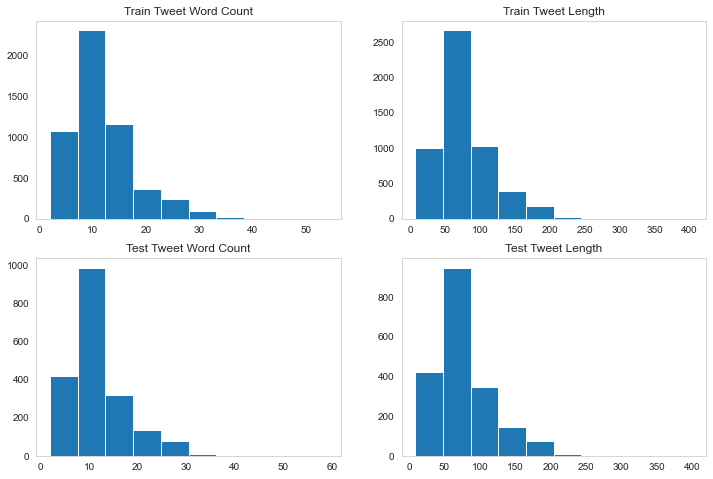

In [79]:
plt.figure(figsize=(12, 8))
plt.subplot(2,2,1)
train["wcount"].hist(grid=False)
plt.title("Train Tweet Word Count")
plt.subplot(2,2,2)
train["tlength"].hist(grid=False)
plt.title("Train Tweet Length")
plt.subplot(2,2,3)
test["wcount"].hist(grid=False)
# print()
# print()
plt.title("Test Tweet Word Count")
plt.subplot(2,2,4)
test["tlength"].hist(grid=False)
plt.title("Test Tweet Length")
plt.show()

#### common words among the negative class

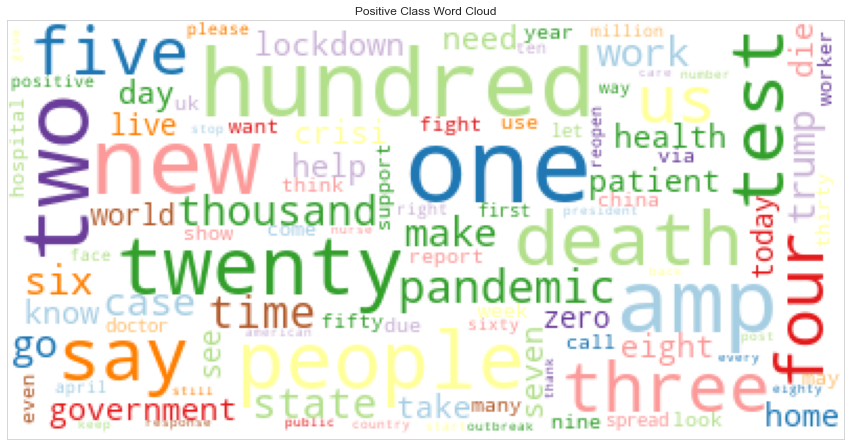

In [44]:
pos_class = train[train["target"] == 1]['clean'].str.cat(sep = ",")
pos_word = (MyTextPlots().plot_word_cloud(pos_class, title='Positive Class Word Cloud', 
                                                 max_words=100, cmap='Paired', 
                                                 figsize=(15, 12), savefig=True)
           )

#### common words among the negative class

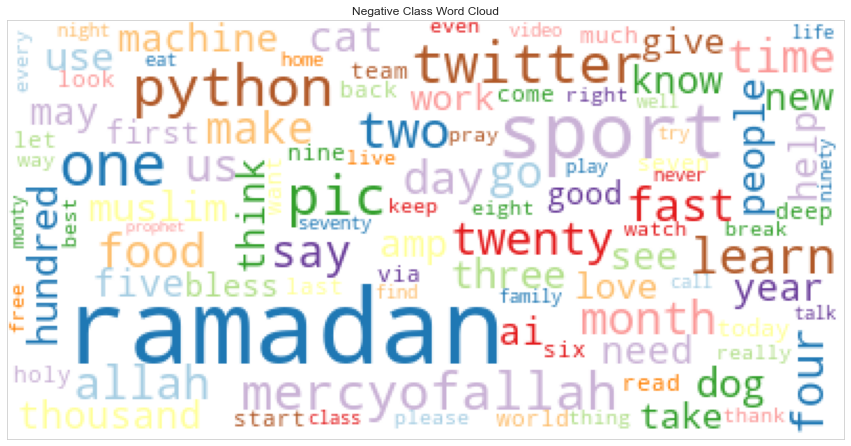

In [47]:
neg_class = train[train["target"] == 0]['clean'].str.cat(sep = ",")
neg_word = (MyTextPlots().plot_word_cloud(neg_class, title='Negative Class Word Cloud', 
                                                 max_words=100, cmap='Paired', 
                                                 figsize=(15, 12), savefig=True)
           )

In [59]:
# train["numericals"] = train["text"].apply(lambda x: len(re.findall(r"\d+", str(x.lower()))))
train["numericals"] = train["text"].apply(lambda x: 1 if(re.search(r"\d+", str(x.lower()))) else 0)

train.groupby("target")["numericals"].describe().T

target,0,1
count,2746.000000,2541.000000
mean,0.287691,0.260527
std,0.452769,0.439009
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [60]:
train[train["numericals"] > 0]["target"].value_counts()

0    790
1    662
Name: target, dtype: int64

In [53]:
text = "I am trying to get numericals 12, FROM the 4 text string 780, "
text = "this is just a text"
re.findall(r"\d+", text.lower())

[]

In [81]:
from textblob import TextBlob

In [87]:
train["polarity"] = train["clean"].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
train["subjectivity"] = train["clean"].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)
# blob = TextBlob(pos_class)

# sentiment = blob.sentiment

# sentiment.polarity

In [91]:
# train.groupby("target")[["polarity", "subjectivity"]].describe().T

### machine learning

In [162]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.base import TransformerMixin, BaseEstimator

In [99]:
X = train["clean"]
y = train["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 27)

#### initial model fit with no param tuning

In [101]:
vect = TfidfVectorizer(ngram_range=(1,2))

pipe = Pipeline([
    ('vect',TfidfVectorizer(ngram_range=(1,2)) ),
    ('svd', TruncatedSVD(algorithm='randomized', n_components=300)),
    ('model', XGBClassifier(n_estimators=250, learning_rate= 0.05, random_state = 27)),
])

pipe.fit(X_train, y_train)
preds = pipe.predict(X_test)
metrics.roc_auc_score(y_test, preds)

In [102]:
metrics.roc_auc_score(X_train, pipe.predict(X_train))

0.890353513668241

In [104]:
metrics.roc_auc_score(y_train, pipe.predict(X_train))

0.9781088756664782

#### cross validation score test to see how our model performs

In [105]:
cv = cross_val_score(pipe, X_train, y_train, scoring='roc_auc', cv = 3)
np.mean(cv), cv

#### parameter tuning using RandomizedSearchCV

In [113]:
param_grid = {
    'vect__ngram_range': [(1,2), (2,3)],
    'svd__n_components': [300, 200],
    'model__n_estimators' :[250, 350,500],
    'model__learning_rate' :[0.01, 0.05, 0.1],
    'model__subsample':[0.2, 0.8, 1],
}

rcv = RandomizedSearchCV(pipe, param_grid, n_iter=10, cv=3, scoring="roc_auc", random_state=27)
rcv.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('vect',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                                              min_df=1,
                                        

In [114]:
rcv.best_params_

{'vect__ngram_range': (1, 2),
 'svd__n_components': 300,
 'model__subsample': 0.8,
 'model__n_estimators': 500,
 'model__learning_rate': 0.05}

In [117]:
rcv.best_score_

0.938903945050964

In [121]:
metrics.roc_auc_score(y_test, rcv.best_estimator_.predict(X_test))

0.8852476026907113

In [160]:
metrics.confusion_matrix(y_test, rcv.best_estimator_.predict(X_test))

array([[491,  57],
       [ 64, 446]], dtype=int64)

#### make submission file

In [122]:
pipe = Pipeline([
    ('vect',TfidfVectorizer(ngram_range=(1,2)) ),
    ('svd', TruncatedSVD(algorithm='randomized', n_components=300, random_state=27)),
    ('model', XGBClassifier(n_estimators=500, subsample=0.8, learning_rate=0.05, random_state=27)),
])

pipe.fit(X, y)
preds_proba = pipe.predict_proba(test["clean"])


In [134]:
preds_proba.reshape(-1,1).shape

(1962, 1)

In [151]:
test.iloc[:, 0].tail()

1957    test_2932
1958    test_2934
1959    test_2936
1960    test_2937
1961    test_2940
Name: ID, dtype: object

In [156]:
preds_proba = pipe.predict_proba(test["clean"])[:,1]

In [158]:
submission = test.iloc[:, 0].to_frame()
submission["target"] = preds_proba.tolist()
submission.head()

,ID,target
0,test_2,0.190166
1,test_3,0.003076
2,test_4,0.024631
3,test_8,0.910682
4,test_9,0.002940


In [159]:
submission.to_csv("submissions/first_xgb.csv", index=None)

### Adding More Features

In [ ]:
class NumberSelector(TransformerMixin, BaseEstiomator):